In [1]:
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import src
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


# Import các hàm xử lý từ src
from src import (
    load_data, 
    impute_categorical, 
    impute_numerical,
    standardize,
    binning_numerical,
    ordinal_encode, 
    one_hot_encode, 
    save_processed_data,
    cap_outliers,
    plot_raw_vs_capping,
    remove_highly_correlated_features,
    plot_raw_vs_standardized 
)

# Cấu hình đường dẫn
PATH_TRAIN = '../data/raw/aug_train.csv'
PATH_TEST = '../data/raw/aug_test.csv'
PATH_PROCESSED_TRAIN = '../data/processed/train_processed.csv'
PATH_PROCESSED_TEST = '../data/processed/test_processed.csv'

# Load dữ liệu thô
print("--- 1. LOAD DATA ---")
train_data, train_header, train_field_map = load_data(PATH_TRAIN)
test_data, test_header, test_field_map = load_data(PATH_TEST)

print(f"Train shape: ({train_data.shape[0]}, {len(train_header)})")
print(f"Test shape: ({test_data.shape[0]}, {len(test_header)})")

--- 1. LOAD DATA ---
Train shape: (19158, 14)
Test shape: (2129, 13)


# Data cleaning

**Xử lý trùng lặp dòng**

In [ ]:
#  Kiểm tra kích thước ban đầu
print(f"Kích thước Train trước khi lọc trùng: {train_data.shape}")

# Loại bỏ dòng trùng lặp
train_data_unique = np.unique(train_data)

# Cập nhật lại train_data
train_data = train_data_unique

# Kiểm tra kết quả
print(f"Kích thước Train sau khi lọc trùng: {train_data.shape}")

Kích thước Train trước khi lọc trùng: (19158,)
Kích thước Train sau khi lọc trùng: (19158,)


**Xử lý dữ liệu thiếu (Missing values)**

- Cột Số (city_development_index): Điền bằng Median (Trung vị) của tập Train. Lý do: Median ít bị ảnh hưởng bởi outliers hơn Mean.
- Cột Danh mục (gender, company_size, ...): Điền bằng giá trị 'Unknown'. Lý do: Việc thiếu thông tin cũng là một tín hiệu (ví dụ: thất nghiệp nên không có công ty), ta giữ lại thông tin này thay vì đoán mò.

In [3]:
# Cột SỐ: Điền bằng Median (Tính từ tập Train)
col_city = 'city_development_index'
# Lấy dữ liệu để tính toán (loại bỏ NaN tạm thời để tính Median)
train_col_data = train_data[train_field_map[col_city]]
valid_data = train_col_data[~np.isnan(train_col_data)]
MEDIAN_CITY = np.median(valid_data)

print(f"-> Điền Missing '{col_city}' bằng Median: {MEDIAN_CITY:.4f}")

# Áp dụng cho cả Train và Test
train_data = impute_numerical(train_data, train_field_map, col_city, MEDIAN_CITY)
test_data = impute_numerical(test_data, test_field_map, col_city, MEDIAN_CITY)


# Cột DANH MỤC: Điền bằng 'Unknown'
cols_cat = ['gender', 'company_size', 'company_type', 'major_discipline', 
            'enrolled_university', 'education_level', 'last_new_job', 'experience']

print(f"-> Điền Missing các cột danh mục bằng 'Unknown'")
for col in cols_cat:
    train_data = impute_categorical(train_data, train_field_map, col)
    test_data = impute_categorical(test_data, test_field_map, col)

-> Điền Missing 'city_development_index' bằng Median: 0.9030
-> Điền Missing các cột danh mục bằng 'Unknown'


**Xử lý dữ liệu nhiễu (Noise values)**

Sử dụng Capping để loại bỏ outlier ở biên đối với các cột dữ liệu số

In [4]:
print("\n--- XỬ LÝ OUTLIERS (CAPPING) ---")
# Xử lý cho Training Hours (thường có outlier lớn)
train_data = cap_outliers(train_data, train_field_map, 'training_hours')
test_data = cap_outliers(test_data, test_field_map, 'training_hours')

# Xử lý cho City Development Index (thường có outlier nhỏ)
train_data = cap_outliers(train_data, train_field_map, 'city_development_index')
test_data = cap_outliers(test_data, test_field_map, 'city_development_index')


--- XỬ LÝ OUTLIERS (CAPPING) ---
Capping 'training_hours': < 3.00 -> 3.00 | > 302.00 -> 302.00
Capping 'training_hours': < 3.00 -> 3.00 | > 298.00 -> 298.00
Capping 'city_development_index': < 0.55 -> 0.55 | > 0.94 -> 0.94
Capping 'city_development_index': < 0.53 -> 0.53 | > 0.94 -> 0.94


--- BẮT ĐẦU CAPPING (WINSORIZING) ---
Capping 'training_hours': < 3.00 -> 3.00 | > 302.00 -> 302.00
Capping 'training_hours': < 3.00 -> 3.00 | > 298.00 -> 298.00
-> Đã xử lý xong: training_hours
Capping 'city_development_index': < 0.55 -> 0.55 | > 0.94 -> 0.94
Capping 'city_development_index': < 0.53 -> 0.53 | > 0.94 -> 0.94
-> Đã xử lý xong: city_development_index


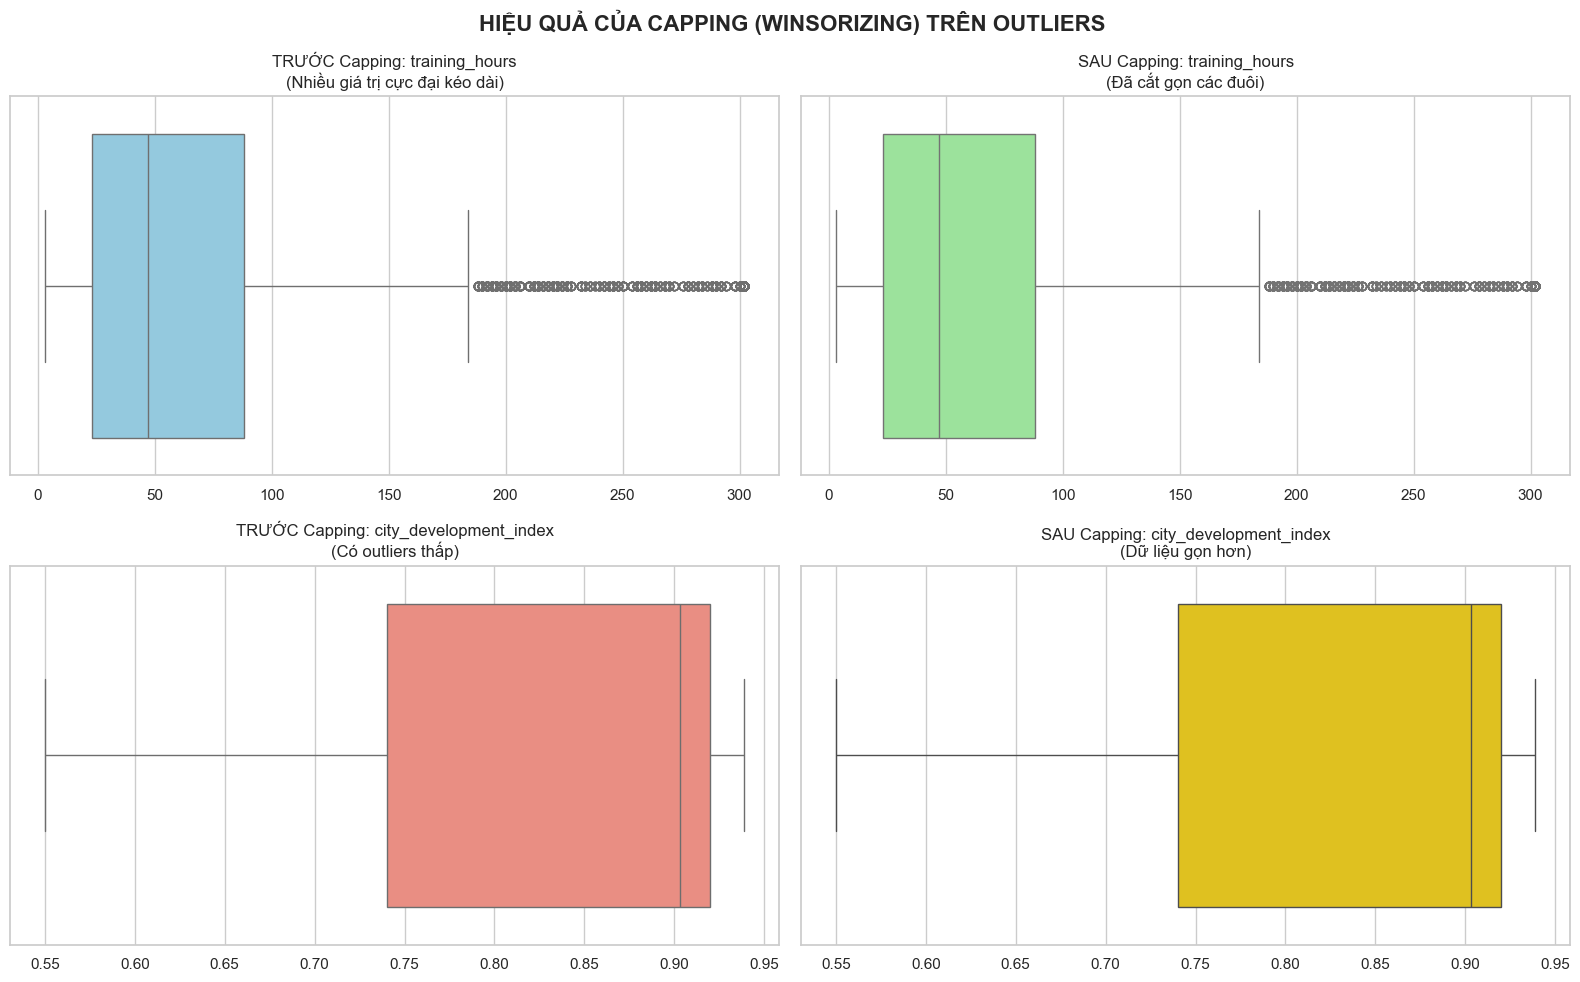

In [ ]:
# Tạo bản sao dữ liệu TRƯỚC khi Capping để so sánh
train_data_before = train_data.copy()

print("--- BẮT ĐẦU CAPPING (WINSORIZING) ---")

# Áp dụng Capping cho Training Hours & City Development Index
# (Capping ở mức 1% và 99%)
cols_to_cap = ['training_hours', 'city_development_index']

for col in cols_to_cap:
    train_data = cap_outliers(train_data, train_field_map, col)
    test_data = cap_outliers(test_data, test_field_map, col) # Áp dụng luôn cho Test
    print(f"-> Đã xử lý xong: {col}")


# Vẽ Boxplot So sánh (Before vs. After)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('HIỆU QUẢ CỦA CAPPING (WINSORIZING) TRÊN OUTLIERS', fontsize=16, fontweight='bold')

# Training Hours ---
col_name = 'training_hours'
field = train_field_map[col_name]

# Trước
sns.boxplot(x=train_data_before[field], ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title(f'TRƯỚC Capping: {col_name}\n(Nhiều giá trị cực đại kéo dài)')

# Sau
sns.boxplot(x=train_data[field], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title(f'SAU Capping: {col_name}\n(Đã cắt gọn các đuôi)')

# City Development Index ---
col_name = 'city_development_index'
field = train_field_map[col_name]

# Trước
sns.boxplot(x=train_data_before[field], ax=axes[1, 0], color='salmon')
axes[1, 0].set_title(f'TRƯỚC Capping: {col_name}\n(Có outliers thấp)')

# Sau
sns.boxplot(x=train_data[field], ax=axes[1, 1], color='gold')
axes[1, 1].set_title(f'SAU Capping: {col_name}\n(Dữ liệu gọn hơn)')

plt.tight_layout()
plt.show()

# Data intergration

Do dữ liệu đầu vào đã được cung cấp dưới dạng bảng đơn nhất (Single Flat File) và đã phân chia sẵn Train/Test, nên bước Data Integration chỉ dừng lại ở việc load dữ liệu và đảm bảo tính đồng nhất trong quy trình xử lý cho cả hai tập đã thể hiện ở cell 1.

# Data Transformation

**Chuẩn hóa Dữ liệu Số (Standardization)**

- Mục tiêu: Đưa các biến số (`city_development_index`) về cùng một thang đo (Mean = 0, Std = 1). ***Binning*** đối với biến `training_hours` dựa trên 01_data_exploration do biến này không có tuyến tính rõ ràng với biến mục tiêu.
- Giải thích: Giúp thuật toán Gradient Descent (trong Logistic Regression) hội tụ nhanh hơn và không bị biến có giá trị lớn lấn át biến nhỏ.

-> Vẽ biểu đồ kiểm tra kết quả chuẩn hóa...


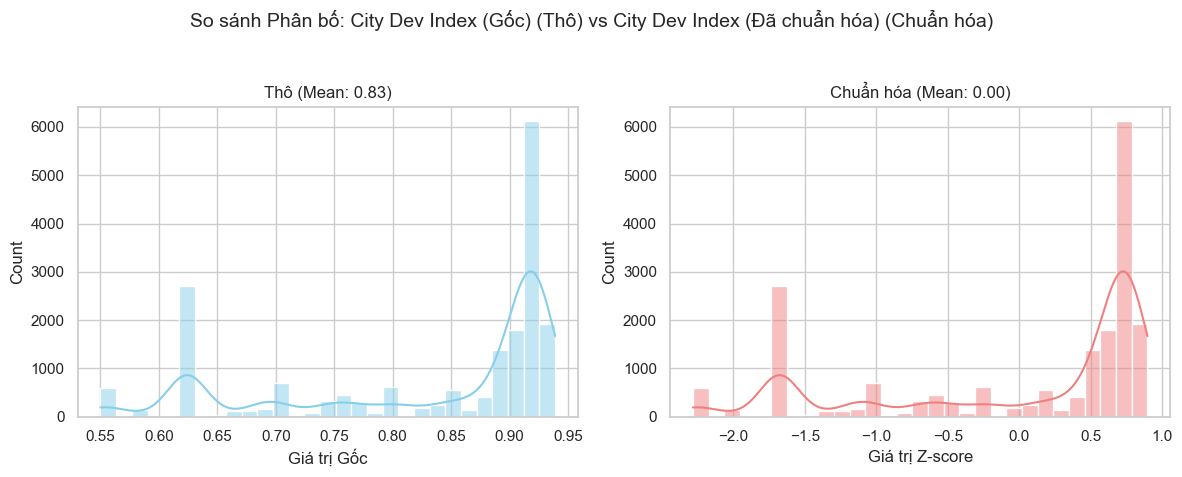

In [6]:
# CHUẨN HÓA (Z-SCORE)
# Chuẩn hóa City Development Index
train_city_std, test_city_std = standardize(
    train_data[train_field_map['city_development_index']], 
    test_data[test_field_map['city_development_index']]
)

# CHUẨN HÓA (Binning)
# Chuẩn hóa Training Hours bằng binning
bins_hours = [0, 20, 50, 100, 200, 10000]
train_hours_binned = binning_numerical(train_data, train_field_map, 'training_hours', bins_hours)
test_hours_binned = binning_numerical(test_data, test_field_map, 'training_hours', bins_hours)

# Kiểm tra trực quan: So sánh phân bố trước và sau chuẩn hóa
print("-> Vẽ biểu đồ kiểm tra kết quả chuẩn hóa...")
plot_raw_vs_standardized(
    train_data[train_field_map['city_development_index']], 
    train_city_std, 
    'City Dev Index (Gốc)', 
    'City Dev Index (Đã chuẩn hóa)'
)

**Mã hóa Dữ liệu Danh mục (Encoding)**

Máy tính chỉ hiểu số, không hiểu chữ. Ta cần chuyển đổi: 
- Ordinal Encoding (Có thứ tự): Dành cho các cột có cấp bậc (experience, company_size, last_new_job). Ví dụ: <1 $ \to $ 0, 1 $ \to $ 1, >20 $ \to $ 21.
- One-Hot Encoding (Không thứ tự): Dành cho các cột định danh (gender, major, company_type). Ví dụ: Male $\to$ [1, 0], Female $\to$ [0, 1].

In [7]:
# MÃ HÓA DỮ LIỆU (ENCODING) 
# A. Ordinal Encoding (Có thứ tự)
# Cần định nghĩa mapping thủ công dựa trên ý nghĩa dữ liệu
exp_map = {
    '<1': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 
    '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, 
    '18': 18, '19': 19, '20': 20, '>20': 21, 'Unknown': -1
}
size_map = {
    '<10': 1, '10-49': 2, '50-99': 3, '100-500': 4, '500-999': 5, 
    '1000-4999': 6, '5000-9999': 7, '10000+': 8, 'Unknown': 0
}
job_map = {
    'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5, 'Unknown': 0
}

# Áp dụng Mapping
print("-> Thực hiện Ordinal Encoding...")
train_exp = ordinal_encode(train_data, train_field_map['experience'], exp_map)
test_exp = ordinal_encode(test_data, test_field_map['experience'], exp_map)

train_size = ordinal_encode(train_data, train_field_map['company_size'], size_map)
test_size = ordinal_encode(test_data, test_field_map['company_size'], size_map)

train_job = ordinal_encode(train_data, train_field_map['last_new_job'], job_map)
test_job = ordinal_encode(test_data, test_field_map['last_new_job'], job_map)


# B. One-Hot Encoding (Định danh - Không thứ tự)
ohe_cols = ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']
ohe_train_list = []
ohe_test_list = []

print(f"-> Thực hiện One-Hot Encoding cho: {ohe_cols}")
for col in ohe_cols:
    tr_ohe, _ = one_hot_encode(train_data, train_field_map, col)
    te_ohe, _ = one_hot_encode(test_data, test_field_map, col)
    ohe_train_list.append(tr_ohe)
    ohe_test_list.append(te_ohe)

-> Thực hiện Ordinal Encoding...
-> Thực hiện One-Hot Encoding cho: ['gender', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']


**Ghép & Lưu trữ (Assemble & Save)**

Hành động: Dùng np.hstack để ghép tất cả các cột đã xử lý (Số đã chuẩn hóa + Ordinal + One-Hot) thành một ma trận lớn.

Lưu: Xuất ra file .csv (dạng số hoàn toàn) vào thư mục data/processed/ để Notebook 03 sử dụng.

In [ ]:
# GHÉP MẢNG & LƯU DỮ LIỆU 

# Gom các cột số và ordinal (Reshape thành cột 2D)
train_numeric_parts = [
    train_city_std[:, np.newaxis],
    train_hours_binned[:, np.newaxis],
    train_exp[:, np.newaxis],
    train_size[:, np.newaxis],
    train_job[:, np.newaxis]
]
test_numeric_parts = [
    test_city_std[:, np.newaxis],
    test_hours_binned[:, np.newaxis],
    test_exp[:, np.newaxis],
    test_size[:, np.newaxis],
    test_job[:, np.newaxis]
]

# Ghép tất cả lại (Numeric + Ordinal + One-Hot)
X_train_final = np.hstack(train_numeric_parts + ohe_train_list)
X_test_final = np.hstack(test_numeric_parts + ohe_test_list)

# Lấy Target ra riêng
Y_train = train_data[train_field_map['target']]

print(f"Kích thước X_train cuối cùng: {X_train_final.shape}")
print(f"Kích thước X_test cuối cùng: {X_test_final.shape}")

# Lưu xuống file CSV
# Ghép X_train và Y_train lại để lưu chung 1 file
save_processed_data(X_train_final, Y_train, X_test_final, PATH_PROCESSED_TRAIN, PATH_PROCESSED_TEST)

Kích thước X_train cuối cùng: (19158, 33)
Kích thước X_test cuối cùng: (2129, 33)
LƯU TRỮ HOÀN TẤT: Đã lưu train data vào ../data/processed/train_processed.csv
LƯU TRỮ HOÀN TẤT: Đã lưu test data vào ../data/processed/test_processed.csv


# Data Reduction

In [9]:
# DATA REDUCTION (LOẠI BỎ ĐA CỘNG TUYẾN)

# Áp dụng trên tập Train để tìm ra các cột cần giữ
X_train_reduced, keep_indices = remove_highly_correlated_features(X_train_final, threshold=0.95)

# Áp dụng ĐÚNG các cột đó cho tập Test (để đồng bộ)
X_test_reduced = X_test_final[:, keep_indices]

print(f"Kích thước X_train sau giảm chiều: {X_train_reduced.shape}")
print(f"Kích thước X_test sau giảm chiều:  {X_test_reduced.shape}")

# Cập nhật lại biến chính để lưu
X_train_final = X_train_reduced
X_test_final = X_test_reduced

-> Đang kiểm tra tương quan (Threshold > 0.95)...
   Không có features nào bị loại.
Kích thước X_train sau giảm chiều: (19158, 33)
Kích thước X_test sau giảm chiều:  (2129, 33)
